In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import optuna
import math
import optuna.visualization as vis
import kagglehub
from IPython.display import display, Markdown


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'
    
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/submission.csv
../kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
../kaggle/input/playground-series-s4e11/sample_submission.csv
../kaggle/input/playground-series-s4e11/test.csv
../kaggle/input/playground-series-s4e11/train.csv


# Load Data

In [ ]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s4e11/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s4e11/sample_submission.csv')
original_data = pd.read_csv(data_path + '/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [17]:
original_data.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


# Overview

## Data Overview

### General Information

- Number of rows and columns: 2556 x 19

- Column names:

['Name',
 'Gender',
 'Age',
 'City',
 'Working Professional or Student',
 'Profession',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression']

### Data Types & Missing Values

,Data Type,Missing Values
Name,object,0
Gender,object,0
Age,int64,0
City,object,0
Working Professional or Student,object,0
Profession,object,673
Academic Pressure,float64,2054
Work Pressure,float64,502
CGPA,float64,2054
Study Satisfaction,float64,2054


### Classic head of Data

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,nan,2.000000,nan,nan,4.000000,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,nan,4.000000,nan,nan,3.000000,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,nan,2.000000,nan,nan,3.000000,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,nan,3.000000,nan,nan,5.000000,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,nan,4.000000,nan,nan,3.000000,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
Age,2556.000000,39.043036,12.260596,18.000000,28.000000,39.000000,50.000000,60.000000
Academic Pressure,502.000000,3.003984,1.390007,1.000000,2.000000,3.000000,4.000000,5.000000
Work Pressure,2054.000000,3.021908,1.417312,1.000000,2.000000,3.000000,4.000000,5.000000
CGPA,502.000000,7.567809,1.465367,5.030000,6.210000,7.605000,8.825000,10.000000
Study Satisfaction,502.000000,3.075697,1.373490,1.000000,2.000000,3.000000,4.000000,5.000000
Job Satisfaction,2054.000000,3.015093,1.418432,1.000000,2.000000,3.000000,4.000000,5.000000
Work/Study Hours,2556.000000,6.023865,3.771743,0.000000,3.000000,6.000000,9.000000,12.000000
Financial Stress,2556.000000,2.968701,1.415527,1.000000,2.000000,3.000000,4.000000,5.000000


## Target Variable: `Depression`

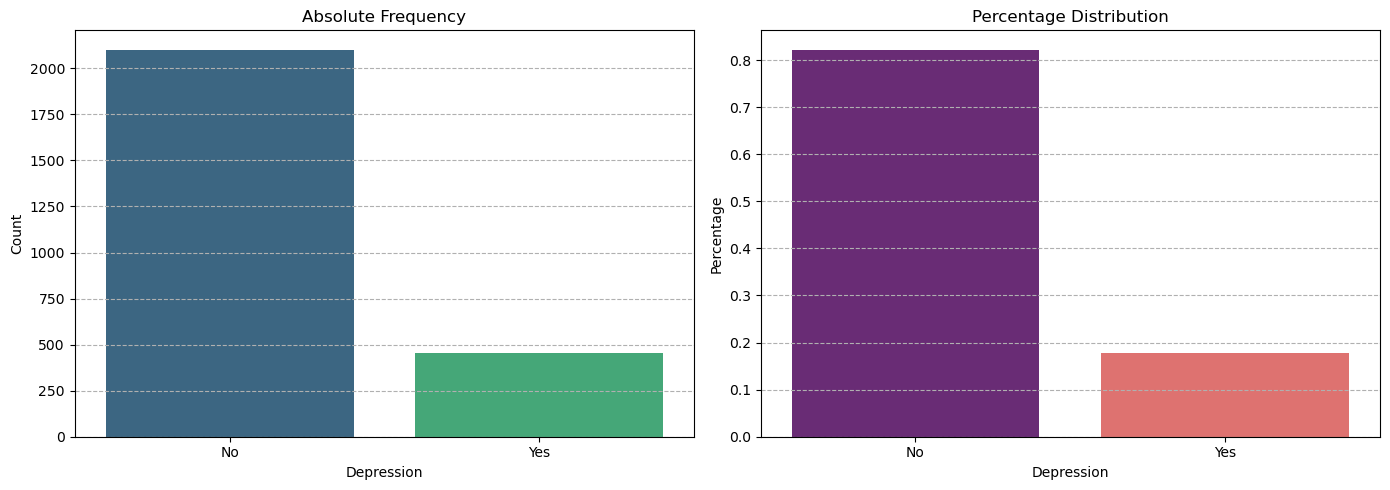

In [ ]:
def data_overview(data, target):
    # Overview
    display(Markdown("## Data Overview"))
    
    display(Markdown("### General Information"))
    display(Markdown(f"- Number of rows and columns: {data.shape[0]} x {data.shape[1]}"))
    display(Markdown("- Column names:"))
    display(list(data.columns))

    display(Markdown("### Data Types & Missing Values"))
    missing = data.isnull().sum()
    dtypes = pd.DataFrame(data.dtypes, columns=["Data Type"])
    missing_df = pd.DataFrame(missing, columns=["Missing Values"])
    overview_df = dtypes.join(missing_df)
    display(overview_df.style.background_gradient(cmap="coolwarm"))

    display(Markdown("### Classic head of Data"))
    display(data.head().style.set_properties(**{"background-color": "#f5f5f5"}))

    display(Markdown("### Statistical Summary (describe)"))
    display(data.describe().T.style.background_gradient(cmap="viridis"))

    # Target variable analysis
    display(Markdown(f"## Target Variable: `{target}`"))
    sns.set_style("whitegrid")  # Dezentes Grid für bessere Lesbarkeit
    sns.set_palette("pastel")   # Sanfte Pastellfarben

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Absolute frequency barplot
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(), 
                ax=ax[0], 
                palette="pastel")  

    ax[0].set_title("Absolute Frequency", fontsize=12, fontweight="bold")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel(target)
    ax[0].grid(axis="y", linestyle="--", alpha=0.5)  # Dezentes Grid

    # Percentage distribution barplot
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(normalize=True), 
                ax=ax[1], 
                palette="Set2")  # Elegante, harmonische Pastellfarben

    ax[1].set_title("Percentage Distribution", fontsize=12, fontweight="bold")
    ax[1].set_ylabel("Percentage")
    ax[1].set_xlabel(target)
    ax[1].grid(axis="y", linestyle="--", alpha=0.5)

    # Entfernt überflüssige Rahmen für minimalistischen Look
    for spine in ["top", "right"]:
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()



'''
'    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot for target variable (classification)
    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(), 
                ax=ax[0],
                palette="viridis")
    ax[0].set_title("Absolute Frequency")
    ax[0].set_ylabel("Count")
    ax[0].grid(axis="y", linestyle="--")

    sns.barplot(x=data[target].value_counts().index, 
                y=data[target].value_counts(normalize=True), 
                ax=ax[1], 
                palette="magma")  # Andere Optionen: "viridis", "Blues", "magma"

    # Percentage distribution
    #data[target].value_counts(normalize=True).plot(kind="bar", ax=ax[1], color="skyblue")
    ax[1].set_title("Percentage Distribution")
    ax[1].set_ylabel("Percentage")
    ax[1].grid(axis="y", linestyle="--")

    plt.tight_layout()
    plt.show()'''


    
data_overview(original_data, 'Depression')
